# Random Forest (Daniel Pak and Harry Wei)

In [ ]:
pip install xgboost

## Comparing Random Forest with XGBoost
A comparison is made between Gradient Boost Regression Model and the Random Foreset Regression Model using Californian housing dataset. Mean absolute error vs N_estimators are compared. As the figure towarsd end of this section shows, RF models converge faster then GB models. However, RF models converge to a higher MAE then GB models over large number of estimator. Due to limitations of computation power and speed of scikit learn RF regressor, this notebook restricts n_estimators to be under 250 and a step size of 10 for Random Forest Models. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import math
import time

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target
y -= y.mean()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
display(X_test.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43


### Gradient Boosted Regressions
In this section, we evaluated the mean absolute error of GBM with n_estimators spanning 1 to 500 for two cases: max depth of 4 and 6 respectively. XGBoost XGBRegressor model is used. Other parameters include learning rate and objective function. Learning rate is set to be 0.05, and reg:squarederror is used for the objective function. Mean absolute error and relative feature importance are later compared to Random Forest Regressor.  

In [ ]:
def gradient_boosted(n_estimators,max_depth,learning_rate, X_train, y_train, X_test, y_test):
  # fit model no training data
  model = XGBRegressor(n_estimators = n_estimators,objective='reg:squarederror',max_depth = max_depth, learning_rate= learning_rate)
  eval_set = [(X_train, y_train), (X_test, y_test)]
  metric = 'mae'
  model.fit(X_train, y_train, eval_metric=[metric], eval_set=eval_set, verbose=0)
  # make predictions for test data
  y_pred = model.predict(X_test)

  # evaluate predictions
  mae = np.mean(abs(y_test-y_pred))
  
  # Retrieve test MAE
  results = model.evals_result()
  epochs = range(0, len(results['validation_1'][metric]))
  mae = results['validation_1'][metric]
  # Retreive rel feature importance, ranked bt importance
  feature_names = X_train.columns
  rel_importance = model.feature_importances_ / max(model.feature_importances_ )
  sorted_idx = np.flip(rel_importance.argsort())
  return {'epochs':epochs,'mae':mae,'feature_names':feature_names[sorted_idx],'rel_importance': rel_importance[sorted_idx]}

In [ ]:
# Some common parameters for GBM
n_estimators_GBM = 250
learning_rate_GBM = 0.05

# MAE and rel importance of GBM with max depth of 4
GBM4_results = gradient_boosted(n_estimators_GBM,4,learning_rate_GBM, X_train, y_train, X_test, y_test)

# MAE and rel importance of GBM with max depth of 6
GBM6_results = gradient_boosted(n_estimators_GBM,6,learning_rate_GBM, X_train, y_train, X_test, y_test)

### Random Forest Functions
In this seciton, we created a wrapper function based on SKlearn RandomForestRegressor. The wrapper function randomforest trains a RF regressor with specified parameters, performs a prediction on the test set, and returns mean absolute error and feature importances. The random_forest_mae function calls randomforest multiple times with increasing number of n_estimators and specified parameters, and records the output n_estimator, performence, and features in a dictionary.

In [ ]:
def randomforest(n_estimators,max_depth,max_features,X_train,y_train,X_test,y_test):
  model = RandomForestRegressor(n_estimators=n_estimators,criterion="mae",max_depth=max_depth,max_features=max_features,n_jobs=-1)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test,y_pred)
  return mae, model.feature_importances_  

def random_forest_mae(n,steps,max_depth,max_features,X_train,y_train,X_test,y_test):
  tic = time.time()
  x_mae = np.arange(1,n+1,steps)
  mae = np.zeros(math.ceil(n/steps))
  for i in range(1,n+1,steps): #can't have n_estimators = 0
    mae[math.floor((i-1)/steps)] = randomforest(i,max_depth,max_features,X_train,y_train,X_test,y_test)[0]
    if i == range(1,n+1,steps)[-1]:
      final_model = randomforest(i,max_depth,max_features,X_train,y_train,X_test,y_test)[1]
  toc = time.time()
  print(f"Finished in {toc-tic} seconds")

  feature_names = X_train.columns
  rel_importance = final_model / max(final_model)
  sorted_idx = np.flip(rel_importance.argsort())

  return {'epochs':x_mae,'mae':mae,'feature_names':feature_names[sorted_idx],'rel_importance': rel_importance[sorted_idx]}

#### Random Forest Regressor m = 2

In [ ]:
n = 250
steps = 10
max_depth = 500
max_features = 2

RF2_results = random_forest_mae(n,steps,max_depth,max_features,X_train,y_train,X_test,y_test)

Finished in 4075.425263404846 seconds


#### Random Forest Regressor m = 6

In [ ]:
n = 250
steps = 10
max_depth = 500
max_features = 6

RF6_results = random_forest_mae(n,steps,max_depth,max_features,X_train,y_train,X_test,y_test)

Finished in 9722.397034406662 seconds


### Overall Plots
Here we replicate the textbook figure 15.3. The plot shows that MAE of RF models converge faster then GB models. However at large number of estimators, GB models attain better performence then RF models, which converges to a minimum MAE higher then that of the GB models.

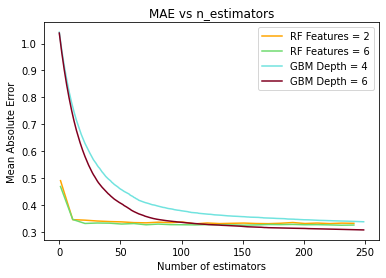

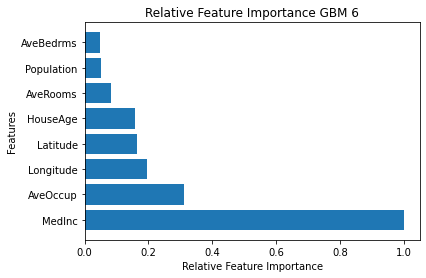

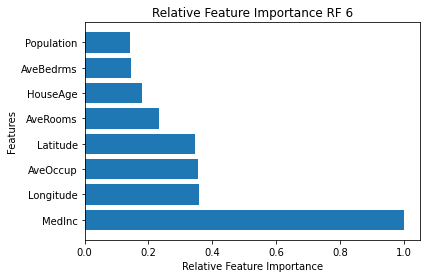

In [ ]:
fig,ax = plt.subplots()
ax.plot(RF2_results.get('epochs'),RF2_results.get('mae'), label='RF Features = 2',color = '#FFA500')
ax.plot(RF6_results.get('epochs'),RF6_results.get('mae'), label='RF Features = 6',color = '#6edb6e')
ax.plot(GBM4_results.get('epochs'),GBM4_results.get('mae'), label='GBM Depth = 4',color = '#71e3df')
ax.plot(GBM6_results.get('epochs'),GBM6_results.get('mae'), label='GBM Depth = 6',color = '#800020')
ax.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Number of estimators')
plt.title('MAE vs n_estimators')
plt.show()

# Plot Relative Feature Importance of GBM 6 model
plt.figure()
plt.title("Relative Feature Importance GBM 6")
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.barh(GBM6_results.get('feature_names'),GBM6_results.get('rel_importance'))
plt.show()

# Plot Relative Feature Importance of RF 6 model
plt.figure()
plt.title("Relative Feature Importance RF 6")
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.barh(RF6_results.get('feature_names'),RF6_results.get('rel_importance'))
plt.show()

For RF, when n > 75, the mean absolute error did not change. It leveled out at aorund 0.48 for max features = 6, and 0.52 for max features = 2. GBM resulted in an overall lower MAE as the number of estimators increased, converging at around 0.3 for both depths. There appeared to be no oscillatory behavior as the MAE converged to a final value.

Comparing RF to GBM, the models selected MedInc as the most important feature. GBM kept all features in the model, yet RF threw out Population, and had an extremely small significance for AveBedrms. 

## Comparison of RF nad GB model on telescope dataset

Just like in assignment 4, we chose [MAGIC Gamma Telescope Data Set](https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) from UCI to train a classification tree using XGboost and RF using Scikit learn respectively, and compare the model specific Classification Error vs number of iterations plot, and relative feature importance plots. The label "class" was chosen such that g (gamma - signal) is 1 and h (hadron - background) is 0.

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


"""
    1.  fLength:  continuous  # major axis of ellipse [mm]
    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
   10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
   11.  class:    g,h         # gamma (signal), hadron (background)
"""

df_col_gamma = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class" ]
df_g = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data",names=df_col_gamma)
df_plot_g = df_g.copy()
classification = {"g": 1,"h": 0}
df_g["class"] = df_g["class"].map(classification) #changes "class" label into binary

Y_g = df_g.pop("class")

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(df_g, Y_g, test_size=0.2, random_state=7)
display(X_train_g.head())
display(y_train_g.head())

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
7026,26.4006,13.2825,2.6508,0.5296,0.2849,18.8617,22.3633,9.7745,31.1550,125.2660
16290,81.0903,37.7359,3.4873,0.1521,0.0926,-96.9642,63.0869,18.4721,3.6095,264.4950
1755,19.1072,12.2813,2.4691,0.5840,0.3379,-17.1689,-14.6245,-6.6801,3.6579,170.5160
13938,41.8730,11.8226,2.6465,0.4711,0.2454,-25.5295,-62.5390,-7.1176,76.8503,234.0699
18511,91.2356,24.8769,2.6258,0.4402,0.2497,-39.2618,-95.4027,-14.1885,13.5704,169.3060


7026     1
16290    0
1755     1
13938    0
18511    0
Name: class, dtype: int64

### Telescope Data Distribution: No clear trend exists to seperate lables
The scatter matrix below is used to show hpw messy the selected dataset is. The MAGIC Gamma Telescope dataset contains 19020 samples and 10 features and a  binary label. There is no clear way to differentiate between g and h for the non diagonal entries as there are no exclusive groupings.

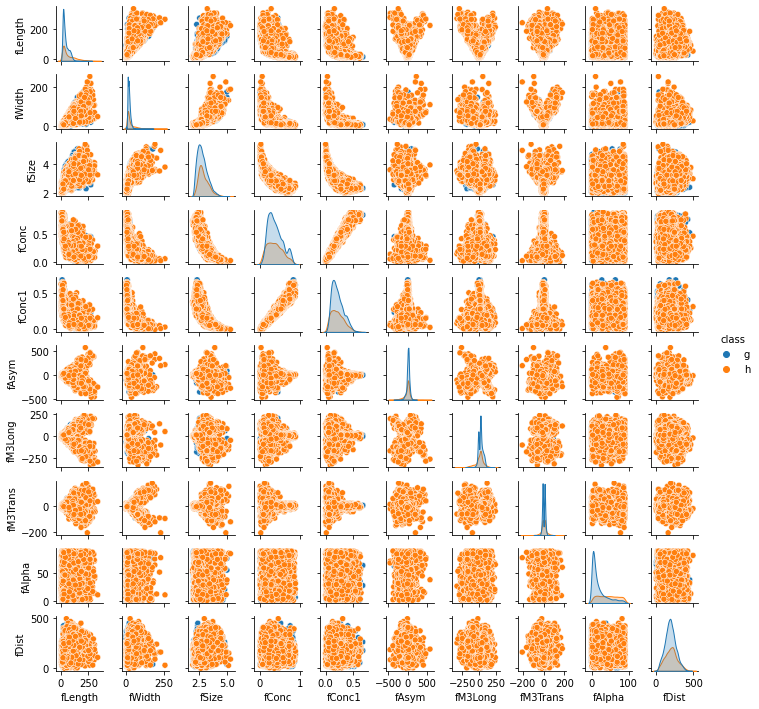

In [ ]:
seaborn.pairplot(df_plot_g, hue = "class", kind='scatter', diag_kind='kde', height=1, 
                 aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)


### Gradient Boosted Classifiers
Similar to Gradient Boost Regression section, we evaluated the mean absolute error of GBM with n_estimators spanning 1 to 1000 for two cases: max depth of 4 and 6 respectively. XGBoost XGBClassifier is used. Other parameters include learning rate and objective function. Learning rate is set to be 0.05, and reg:logistic is used for the objective function. Mean absolute error and relative feature importance are later compared to Random Forest Regressor.

In [ ]:
def gradient_boosted_clf(n_estimators,max_depth,learning_rate, X_train, y_train, X_test, y_test):
  # fit model no training data
  model = XGBClassifier(n_estimators = n_estimators,objective='reg:logistic',max_depth = max_depth, learning_rate= learning_rate)
  eval_set = [(X_train, y_train), (X_test, y_test)]
  metric = 'error'
  model.fit(X_train, y_train, eval_metric=[metric], eval_set=eval_set, verbose=0)
  # make predictions for test data
  y_pred = model.predict(X_test)
  
  # Retrieve test MAE
  results = model.evals_result()
  epochs = range(0, len(results['validation_1'][metric]))
  error = results['validation_1'][metric]
  # Retreive rel feature importance, ranked bt importance
  feature_names = X_train.columns
  rel_importance = model.feature_importances_ / max(model.feature_importances_ )
  sorted_idx = np.flip(rel_importance.argsort())
  return {'epochs':epochs,'error':error,'feature_names':feature_names[sorted_idx],'rel_importance': rel_importance[sorted_idx]}

In [ ]:
# Some common parameters for GBM
n_estimators_GBM = 500
learning_rate_GBM = 0.05

# MAE and rel importance of GBM with max depth of 4
GBM4_results_clf = gradient_boosted_clf(n_estimators_GBM,4,learning_rate_GBM, X_train_g, y_train_g, X_test_g, y_test_g)

# MAE and rel importance of GBM with max depth of 6
GBM6_results_clf = gradient_boosted_clf(n_estimators_GBM,6,learning_rate_GBM, X_train_g, y_train_g, X_test_g, y_test_g)

### Random Forest Classifiers
Similar to the Random Forest Regresor Section, this we created a wrapper function based on SKlearn RandomForestClassifier. The wrapper function trains a RF classifier with specified parameters, performs a prediction on the test set, and returns percent error and feature importances. The random_forest_error_clf function calls randomforest_clf multiple times with increasing number of n_estimators and specified parameters, and records the output n_estimator, performence (%error), and features in a dictionary.

In [ ]:
def randomforest_clf(n_estimators,max_depth,max_features,X_train,y_train,X_test,y_test):
  model = RandomForestClassifier(n_estimators=n_estimators,criterion="gini",max_depth=max_depth,max_features=max_features,n_jobs=-1)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  error = 1 - accuracy_score(y_test,y_pred,normalize=True)
  return error, model.feature_importances_  

def random_forest_error_clf(n,steps,max_depth,max_features,X_train,y_train,X_test,y_test):
  tic = time.time()
  epochs = np.arange(1,n+1,steps)
  error = np.zeros(math.ceil(n/steps))
  for i in range(1,n+1,steps): #can't have n_estimators = 0
    error[math.floor((i-1)/steps)] = randomforest_clf(i,max_depth,max_features,X_train,y_train,X_test,y_test)[0]
    if i == range(1,n+1,steps)[-1]:
      final_model = randomforest_clf(i,max_depth,max_features,X_train,y_train,X_test,y_test)[1]
  toc = time.time()
  print(f"Finished in {toc-tic} seconds")

  feature_names = X_train.columns
  rel_importance = final_model / max(final_model)
  sorted_idx = np.flip(rel_importance.argsort())

  return {'epochs':epochs,'error':error,'feature_names':feature_names[sorted_idx],'rel_importance': rel_importance[sorted_idx]}

#### Random Forest clf m = 2

In [ ]:
n = 500
steps = 5
max_depth = 500
max_features = 2

RF2_results_clf = random_forest_error_clf(n,steps,max_depth,max_features,X_train_g, y_train_g, X_test_g, y_test_g)

Finished in 743.6563279628754 seconds


#### Random Forest clf m = 6

In [ ]:
n = 500
steps = 5
max_depth = 500
max_features = 6

RF6_results_clf = random_forest_error_clf(n,steps,max_depth,max_features,X_train_g, y_train_g, X_test_g, y_test_g)

Finished in 1868.5094199180603 seconds


### Overall Plots

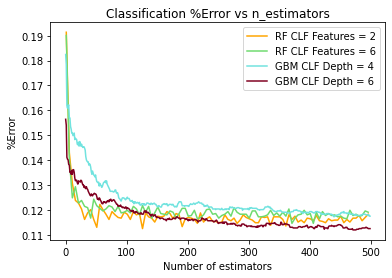

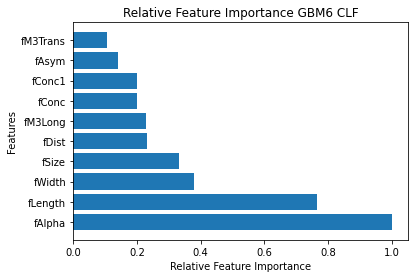

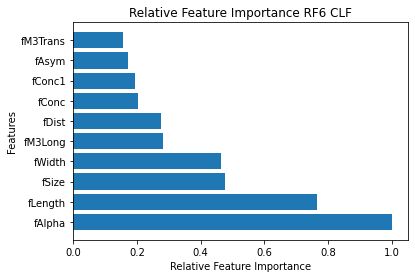

In [ ]:
fig,ax = plt.subplots()
ax.plot(RF2_results_clf.get('epochs'),RF2_results_clf.get('error'), label='RF CLF Features = 2',color = '#FFA500')
ax.plot(RF6_results_clf.get('epochs'),RF6_results_clf.get('error'), label='RF CLF Features = 6',color = '#6edb6e')
ax.plot(GBM4_results_clf.get('epochs'),GBM4_results_clf.get('error'), label='GBM CLF Depth = 4',color = '#71e3df')
ax.plot(GBM6_results_clf.get('epochs'),GBM6_results_clf.get('error'), label='GBM CLF Depth = 6',color = '#800020')
ax.legend()
plt.ylabel('%Error')
plt.xlabel('Number of estimators')
plt.title('Classification %Error vs n_estimators')
plt.show()

# Plot Relative Feature Importance of GBM 6 model
plt.figure()
plt.title("Relative Feature Importance GBM6 CLF")
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.barh(GBM6_results_clf.get('feature_names'),GBM6_results_clf.get('rel_importance'))
plt.show()

# Plot Relative Feature Importance of RF 6 model
plt.figure()
plt.title("Relative Feature Importance RF6 CLF")
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.barh(RF6_results_clf.get('feature_names'),RF6_results_clf.get('rel_importance'))
plt.show()

For RF, when n > 100, the mean absolute error did not change on average. It had oscillatory behaviors as n increased, and didn't converge to a single value for our n estimtors between 1 to 500. Max features of 6 converged to 0.13 while max features of 2 converged to 0.165. GBM resulted in an overall lower MAE as the number of estimators increased. Max depth of 4 converged at around 0.12 while max depth of 6 converged at around 0.11. We think that RF didn't converge that a final value, and didn't have a smooth MAE function due to the dataset having no clear boundaries between hadrons and gamma as indicated on the distribution of data plot.

Comparing RF to GBM, the models selected fAlpha as the most important feature. GBM kept all features in the model, yet RF had small significances for fM3Trans, fASym, FConc1, and FConc1. 